# Land Carbon Analysis

This notebook will provide examples for visualizing carbon on land

Abigail Swann

uses the NPL 2023a environment

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pandas as pd


#### load time series of some relevant variables from the HOPE ensemble

##### Data is located here: /glade/campaign/cesm/community/bgcwg/HOPE


There are several experiments, each with several ensemble members:  
b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001

b.e21.BSSP119.f09_g17.hopens-reference.esmfirebvoc.001

b.e21.BSSP245.f09_g17.hopens-reference.esmfirebvoc.001

b.e21.BSSP370.f09_g17.hopens-reference.esmfirebvoc.001




In [2]:
# data location on campaign
datapath = '/glade/campaign/cesm/community/bgcwg/HOPE/'

# list of all unique case types, each with 3 or 5 ensemble members
casenamelist=['b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.00',
              'b.e21.BSSP119.f09_g17.hopens-reference.esmfirebvoc.00',
              'b.e21.BSSP245.f09_g17.hopens-reference.esmfirebvoc.00',
              'b.e21.BSSP370.f09_g17.hopens-reference.esmfirebvoc.00']

shortnames=['BHIST','BSSP119','BSSP245','BSSP370'] # short names that are more suitable for displaying on plots
ensnumlist = [4,4,4,2] # list of how many ensemble members for each experiment, indexed from zero

colorlist = ['black','#00a9cf','#f69320','#df0000'] # specify the colors associated with these SSPs

# example of how to select a single ensemble member
ensm=0
c=0
casename = casenamelist[c] +str(ensm+1)
casenameshort = shortnames[c] +str(ensm+1)

print('casename = ' +casename)

# or just specify the whole name
#casename = 'b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.003'


casename = b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001


#### Some releavant land carbon variables

TOTECOSYSC = total ecosystem carbon  
TOTSOMC = total soil carbon  
TOTVEGC = total vegetation carbon  
TOTLITC = total litter carbon  
NBP = net biosphere production (net land carbon flux)  
GPP = gross primary production (gross land carbon uptake)  
RH = heterotropic respiration (land flux to atmosphere from soil)  


In [3]:
# this list is repeated farther down when data is loaded. You can add any land variables here
varlist = ['TOTECOSYSC','TOTSOMC','TOTVEGC','TOTLITC','NBP','GPP','RH']

In [4]:
def weighted_temporal_mean(ds, var):
    """
    takes an annual average weighted by days in each month

    Args:
    - ds: xarray dataset with monthly resolution data
    - var: variable name to be averaged

    Returns:
    - the weighted average

    Example Usage: 
    
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="YS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="YS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [5]:
def area_weighted_gobal_average(ds:xr.DataArray, var):
    """
    This function makes a regional average over land for the specified latitude and longitude box

    Args:
    - ds: xarray dataset containing "area" and "landfrac"

    Returns:
    - the weighted average
    
    """
        
    dim='lat','lon'
    xa_copy:xr.DataArray = ds[var].copy()
    xa=ds[var]
    
    weights = ds.area*ds.landfrac
    _, weights_all_dims = xr.broadcast(xa, weights)  # broadcast to all dims
    x_times_w = xa_copy * weights_all_dims
    xw_sum = x_times_w.sum(dim)
    x_tot = weights_all_dims.where(xa_copy.notnull()).sum(dim=dim)
    xa_weighted_average = xw_sum / x_tot

    return xa_weighted_average


In [6]:
def area_weighted_regional_average(ds:xr.DataArray, var, lat_max, lat_min, lon_max, lon_min):
    """
    This function makes a regional average over land for the specified latitude and longitude box

    Args:
    - ds: xarray dataset containing "area" and "landfrac"
    - lat_max: maximum latitude of region
    - lat_min: minimum latitude of region
    - lon_max: maximum longitude of region
    - lon_min: minimum longitude of region

    Returns:
    - the weighted average
    
    """
        
    dim='lat','lon'
    xa=ds[var].sel(lat=slice(lat_min ,lat_max), lon=slice(lon_min,lon_max))
    xa_copy:xr.DataArray = xa.copy()

    
    weights = ds.area*ds.landfrac
    _, weights_all_dims = xr.broadcast(xa, weights)  # broadcast to all dims
    x_times_w = xa_copy * weights_all_dims
    xw_sum = x_times_w.sum(dim)
    x_tot = weights_all_dims.where(xa_copy.notnull()).sum(dim=dim)
    xa_weighted_average = xw_sum / x_tot

    return xa_weighted_average


## Load Data

#### for a single ensemble member

In [34]:
# example of how to select a single ensemble member
ensm=0
c=0
casename = casenamelist[c] +str(ensm+1)
casenameshort = shortnames[c] +str(ensm+1)

print('casename = ' +casename)

casename = b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001


In [38]:
# example to load one ensemble member into dataset called ds_r

# to load multiple variables you can use xarray's open_mfdataset
# you probably don't want to load them all, but you can select a subset of variabiles like this
varlist = ['TOTECOSYSC','TOTSOMC','TOTVEGC','TOTLITC','NBP','GPP','ER']

filenamelist=[]

for v in range(len(varlist)):
    var=varlist[v]
    filenames = glob.glob(datapath + casename +'/lnd/proc/tseries/month_1/*.' +var +'.*.nc')

    filenamelist=filenamelist+filenames

# open all of the files in filenamelist into on xarray dataset named ds_r
ds_r = xr.open_mfdataset(filenamelist)

# save the land area for this grid in ds_ens
landarea = (ds_r.area*ds_r.landfrac)

In [9]:
ds_r

<xarray.Dataset>
Dimensions:       (levgrnd: 25, levlak: 10, levdcmp: 25, lon: 288, lat: 192,
                   time: 1980, hist_interval: 2)
Coordinates:
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * lon           (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat           (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * time          (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: hist_interval
Data variables: (12/27)
    area          (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    landfrac      (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    landmask      (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    pftmask       (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    nbedrock      (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    ZSOI          (levgrnd, lat, lon) float32 dask.array<chunksize=(25, 192, 288), meta=np.ndarray>
    ...            ...
    GPP           (time, lat, lon) float32 dask.array<chunksize=(1980, 192, 288), meta=np.ndarray>
    NBP           (time, lat, lon) float32 dask.array<chunksize=(1980, 192, 288), meta=np.ndarray>
    TOTECOSYSC    (time, lat, lon) float32 dask.array<chunksize=(1980, 192, 288), meta=np.ndarray>
    TOTLITC       (time, lat, lon) float32 dask.array<chunksize=(1980, 192, 288), meta=np.ndarray>
    TOTSOMC       (time, lat, lon) float32 dask.array<chunksize=(1980, 192, 288), meta=np.ndarray>
    TOTVEGC       (time, lat, lon) float32 dask.array<chunksize=(1980, 192, 288), meta=np.ndarray>
Attributes: (12/100)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 06/21/24 01:31:30
    source:                                    Community Land Model CLM4.0
    hostname:                                  derecho
    ...                                        ...
    cft_irrigated_switchgrass:                 60
    cft_tropical_corn:                         61
    cft_irrigated_tropical_corn:               62
    cft_tropical_soybean:                      63
    cft_irrigated_tropical_soybean:            64
    time_period_freq:                          month_1

#### Select one variable to look at 

In [10]:
ds = ds_r
var='TOTECOSYSC'

#### Plot a quick map

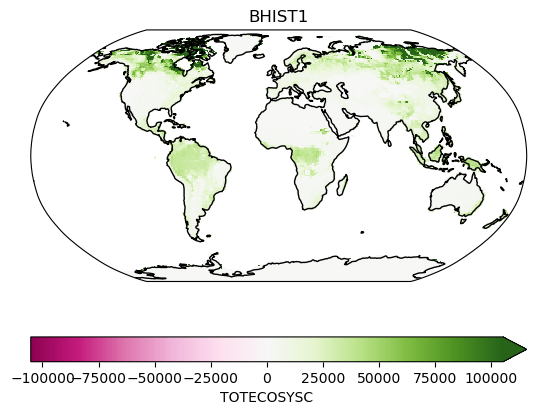

In [11]:
# make a map of the avearge in time
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Robinson()))

data_to_plot = ds_r[var].mean(dim='time')

# to deal with outlier points, set max and min values using percentiles
max_ = np.nanpercentile(data_to_plot, 96)

# plot map using xarray
data_to_plot.plot(ax=axis,transform=ccrs.PlateCarree(), 
                                cbar_kwargs={'orientation': 'horizontal'},
                                cmap='PiYG', vmin=-max_, vmax=max_)

plt.title(casenameshort) # add a title

axis.coastlines()  # cartopy function

#### Plot global average time series

Text(0, 0.5, 'TOTECOSYSC')

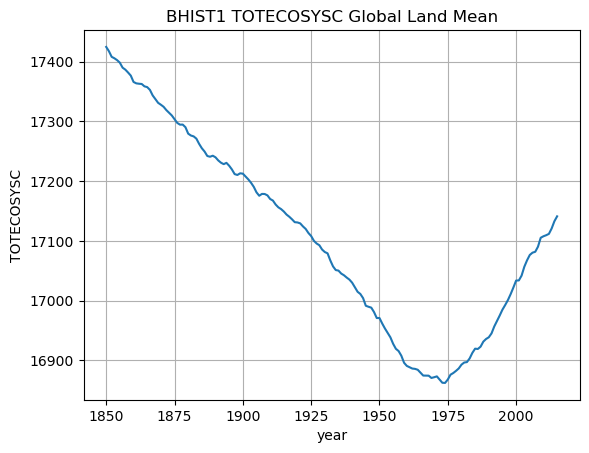

In [12]:
# to average over a region we need to weight by land area
landarea = (ds_r.area*ds_r.landfrac)

#global mean example area weighted average
glob_mean = area_weighted_gobal_average(ds, var)

#average from monthly to annual resolution and plot
glob_annual_mean = glob_mean.groupby(ds['time.year']).mean(dim='time')

glob_annual_mean.plot()
plt.title(casenameshort +' ' +var +' Global Land Mean')
plt.grid()
plt.ylabel(var)

#### Plot regional average time series

Text(0, 0.5, 'TOTECOSYSC')

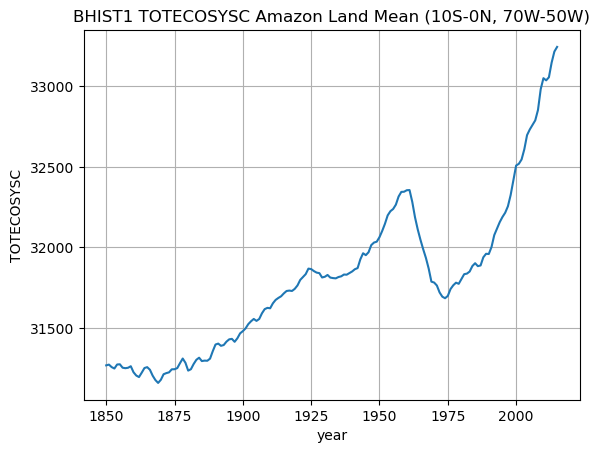

In [13]:
# how to select a region using lat and lon
lon_min = 360-70
lon_max = 360-50
lat_min = -10
lat_max = 0

#regional average example
amazon_mean = area_weighted_regional_average(ds, var, lat_max, lat_min, lon_max, lon_min)

# calculate annual mean and plot time series for the regional average
(amazon_mean.groupby(amazon_mean['time.year']).mean(dim='time')).plot()
plt.title(casenameshort +' ' +var +' Amazon Land Mean (10S-0N, 70W-50W)')
plt.grid()
plt.ylabel(var)

#### Plot a map of the difference at the end of the experiment vs the beginning

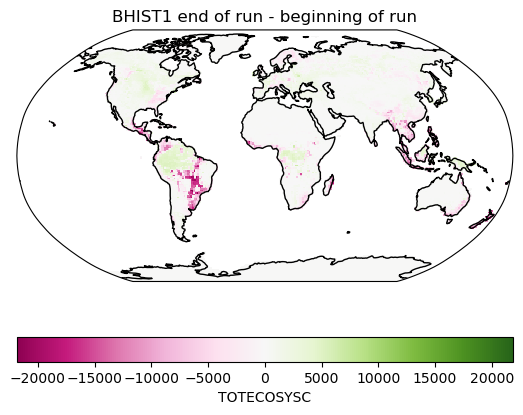

In [14]:
# make a map of the avearge in time
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Robinson()))

# the years specified here assume a historical run - needs to be modified for a future run
if c==0: #historical experiment
    endyear = 2015
    startyear = 1850
else: #future experiment
    endyear = 2100
    startyear = 2016
    
end_run = (ds_r[var].groupby(ds_r['time.year']).mean(dim='time')).sel(year=slice(endyear-20 ,endyear))
beg_run = (ds_r[var].groupby(ds_r['time.year']).mean(dim='time')).sel(year=slice(startyear ,startyear+1))
ds_timediff = end_run.mean(dim='year') - beg_run.mean(dim='year')

# plot map using xarray
ds_timediff.plot(ax=axis,transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'},cmap='PiYG')

plt.title(casenameshort +' end of run - beginning of run') # add a title

axis.coastlines()  # cartopy function

### Plot land carbon budget time series

Text(0, 0.5, 'Carbon Pool (gC/m^2)')

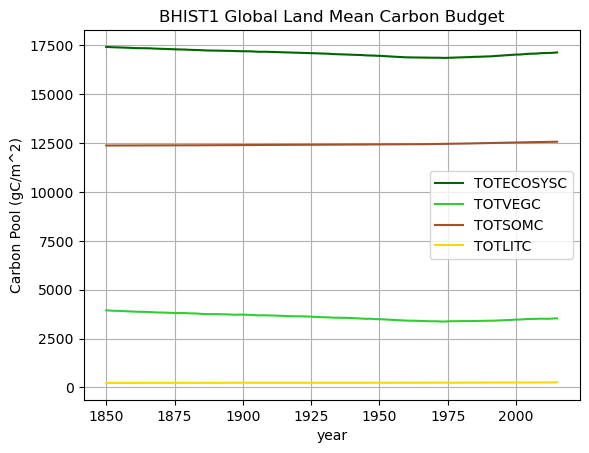

In [41]:
fig, axis = plt.subplots(1, 1)

# to average over a region we need to weight by land area
landarea = (ds_r.area*ds_r.landfrac)

var = 'TOTECOSYSC'
linecolor='darkgreen'
#global mean example area weighted average
glob_mean = area_weighted_gobal_average(ds_r, var)

#average from monthly to annual resolution and plot
glob_annual_mean = glob_mean.groupby(ds_r['time.year']).mean(dim='time')

glob_annual_mean.plot(ax=axis, color=linecolor,label=var)



var = 'TOTVEGC'
linecolor='limegreen'
#global mean example area weighted average
glob_mean = area_weighted_gobal_average(ds_r, var)

#average from monthly to annual resolution and plot
glob_annual_mean = glob_mean.groupby(ds_r['time.year']).mean(dim='time')

glob_annual_mean.plot(ax=axis, color=linecolor,label=var)


var = 'TOTSOMC'
linecolor='sienna'
#global mean example area weighted average
glob_mean = area_weighted_gobal_average(ds_r, var)

#average from monthly to annual resolution and plot
glob_annual_mean = glob_mean.groupby(ds_r['time.year']).mean(dim='time')

glob_annual_mean.plot(ax=axis, color=linecolor,label=var)

var = 'TOTLITC'
linecolor='gold'
#global mean example area weighted average
glob_mean = area_weighted_gobal_average(ds_r, var)

#average from monthly to annual resolution and plot
glob_annual_mean = glob_mean.groupby(ds_r['time.year']).mean(dim='time')

glob_annual_mean.plot(ax=axis, color=linecolor,label=var)



plt.title(casenameshort +' Global Land Mean Carbon Budget')
plt.grid()
plt.legend()
plt.ylabel('Carbon Pool (gC/m^2)')

### Plot global land fluxes over time

Text(0, 0.5, 'Carbon Flux (gC/m^2/s)')

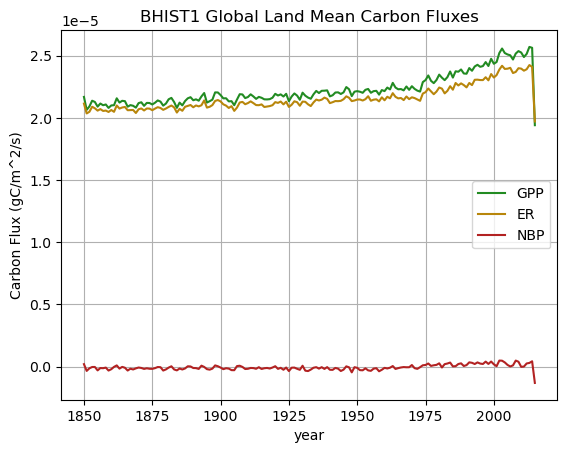

In [40]:
fig, axis = plt.subplots(1, 1)

# to average over a region we need to weight by land area
landarea = (ds_r.area*ds_r.landfrac)

var = 'GPP'
linecolor='forestgreen'
#global mean example area weighted average
glob_mean = area_weighted_gobal_average(ds_r, var)

#average from monthly to annual resolution and plot
glob_annual_mean = glob_mean.groupby(ds_r['time.year']).mean(dim='time')

glob_annual_mean.plot(ax=axis, color=linecolor,label=var)



var = 'ER'
linecolor='darkgoldenrod'
#global mean example area weighted average
glob_mean = area_weighted_gobal_average(ds_r, var)

#average from monthly to annual resolution and plot
glob_annual_mean = glob_mean.groupby(ds_r['time.year']).mean(dim='time')

glob_annual_mean.plot(ax=axis, color=linecolor,label=var)


var = 'NBP'
linecolor='firebrick'
#global mean example area weighted average
glob_mean = area_weighted_gobal_average(ds_r, var)

#average from monthly to annual resolution and plot
glob_annual_mean = glob_mean.groupby(ds_r['time.year']).mean(dim='time')

glob_annual_mean.plot(ax=axis, color=linecolor,label=var)



plt.title(casenameshort +' Global Land Mean Carbon Fluxes')
plt.grid()
plt.legend()
plt.ylabel('Carbon Flux (gC/m^2/s)')

## Load all ensemble members for all experiments into a dictionary

In [15]:
# now lets load all ensemble members for a given experiment

# to load multiple variables you can use xarray's open_mfdataset
# you probably don't want to load them all, but you can select a subset of variabiles like this
varlist = ['TOTECOSYSC','TOTSOMC','TOTVEGC','TOTLITC','NBP','GPP','ER']

# initialize a dictionary to hold all of the data
data_dict={}

# loop over experiments
for c in range(len(casenamelist)): # select an experiment
        
    # loop over ensemble members
    for ensm in range(ensnumlist[c]+1): # select an ensemble member
        
        casename = casenamelist[c] +str(ensm+1) #create a string of the casename
        casenameshort = shortnames[c] +str(ensm+1) #create a string of the short casename
        
        filenamelist=[] # initialize an empty list of files
        
        for v in range(len(varlist)):
            var=varlist[v] 
            # get a list of all files matching casename and varname
            filenames = glob.glob(datapath + casename +'/lnd/proc/tseries/month_1/*.' +var +'.*.nc')
        
            filenamelist=filenamelist+filenames # add the list to the prior lists
        
        # open all of the files in filenamelist into on xarray dataset named ds_r
        ds_r = xr.open_mfdataset(filenamelist)
    
        #----save output to a dictionary----#
        print('adding ' +casenameshort +' to dict')
        data_dict[casename] = ds_r


    

adding BHIST1 to dict
adding BHIST2 to dict
adding BHIST3 to dict
adding BHIST4 to dict
adding BHIST5 to dict
adding BSSP1191 to dict
adding BSSP1192 to dict
adding BSSP1193 to dict
adding BSSP1194 to dict
adding BSSP1195 to dict
adding BSSP2451 to dict
adding BSSP2452 to dict
adding BSSP2453 to dict
adding BSSP2454 to dict
adding BSSP2455 to dict
adding BSSP3701 to dict
adding BSSP3702 to dict
adding BSSP3703 to dict


#### Plot time series of all ensemble members for one experiment on one plot

plotting experiment BHIST


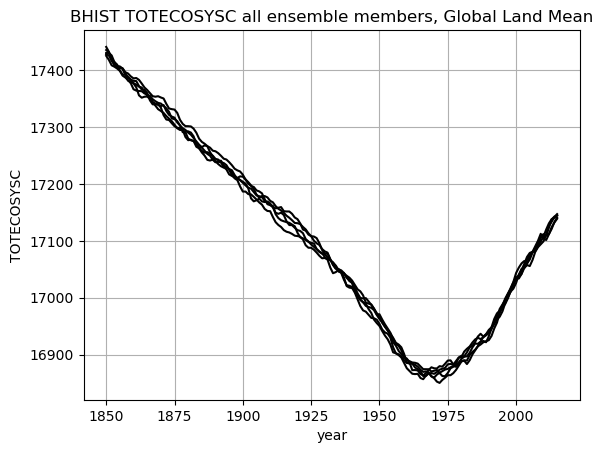

In [16]:
var = 'TOTECOSYSC'

fig, axis = plt.subplots(1, 1) # initialize a figure

# select an experiemnt
c = 0
casenameshort = shortnames[c] #create a string of the short casename
print('plotting experiment ' +casenameshort)

# loop over ensemble members
for ensm in range(ensnumlist[c]+1): # select an ensemble member
    
    casename = casenamelist[c] +str(ensm+1) #create a string of the casename

    ds = data_dict[casename] # retrieve the dataset from the dictionary of datasets
    
    # to average over a region we need to weight by land area
    landarea = (ds.area*ds.landfrac)
    
    #global mean example area weighted average
    glob_mean = area_weighted_gobal_average(ds,var)
    
    #average from monthly to annual resolution and plot
    glob_annual_mean = glob_mean.groupby(ds['time.year']).mean(dim='time')
    
    glob_annual_mean.plot(ax=axis, color=colorlist[c])

plt.title(casenameshort +' ' +var +' all ensemble members, Global Land Mean')
plt.ylabel(var)
plt.grid()

#### Plot all experiments and all ensemble members on the same plot

plotting experiment BHIST
plotting experiment BSSP119
plotting experiment BSSP245
plotting experiment BSSP370


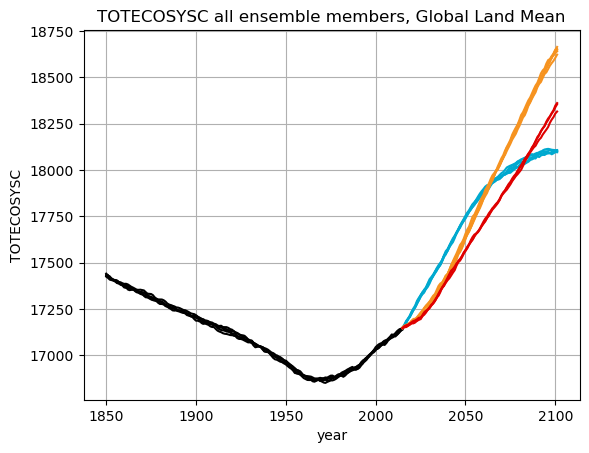

In [17]:
var = 'TOTECOSYSC'

fig, axis = plt.subplots(1, 1) # initialize a figure

# loop over experiments
for c in range(len(casenamelist)): # select an experiment
       # select an experiemnt

    casenameshort = shortnames[c] #create a string of the short casename
    print('plotting experiment ' +casenameshort)
    
    # loop over ensemble members
    for ensm in range(ensnumlist[c]+1): # select an ensemble member
        
        casename = casenamelist[c] +str(ensm+1) #create a string of the casename
    
        ds = data_dict[casename] # retrieve the dataset from the dictionary of datasets
        
        # to average over a region we need to weight by land area
        landarea = (ds.area*ds.landfrac)
        
        #global mean example area weighted average
        glob_mean = area_weighted_gobal_average(ds,var)
        
        #average from monthly to annual resolution and plot
        glob_annual_mean = glob_mean.groupby(ds['time.year']).mean(dim='time')
        
        glob_annual_mean.plot(ax=axis, color=colorlist[c])

plt.title(var +' all ensemble members, Global Land Mean')
plt.ylabel(var)
plt.grid()

plotting experiment BHIST
plotting experiment BSSP119
plotting experiment BSSP245
plotting experiment BSSP370


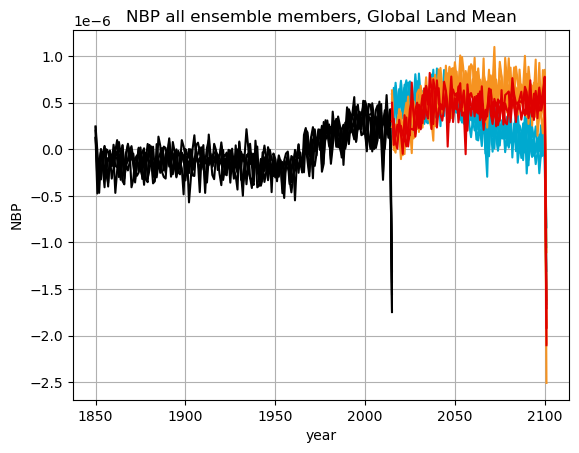

In [18]:
var = 'NBP'

fig, axis = plt.subplots(1, 1) # initialize a figure

# loop over experiments
for c in range(len(casenamelist)): # select an experiment
       # select an experiemnt

    casenameshort = shortnames[c] #create a string of the short casename
    print('plotting experiment ' +casenameshort)
    
    # loop over ensemble members
    for ensm in range(ensnumlist[c]+1): # select an ensemble member
        
        casename = casenamelist[c] +str(ensm+1) #create a string of the casename
    
        ds = data_dict[casename] # retrieve the dataset from the dictionary of datasets
        
        # to average over a region we need to weight by land area
        landarea = (ds.area*ds.landfrac)
        
        #global mean example area weighted average
        glob_mean = area_weighted_gobal_average(ds,var)
        
        #average from monthly to annual resolution and plot
        glob_annual_mean = glob_mean.groupby(ds['time.year']).mean(dim='time')
        
        glob_annual_mean.plot(ax=axis, color=colorlist[c])

plt.title(var +' all ensemble members, Global Land Mean')
plt.ylabel(var)
plt.grid()

### Zonal mean plots

Text(0, 0.5, 'latitude')

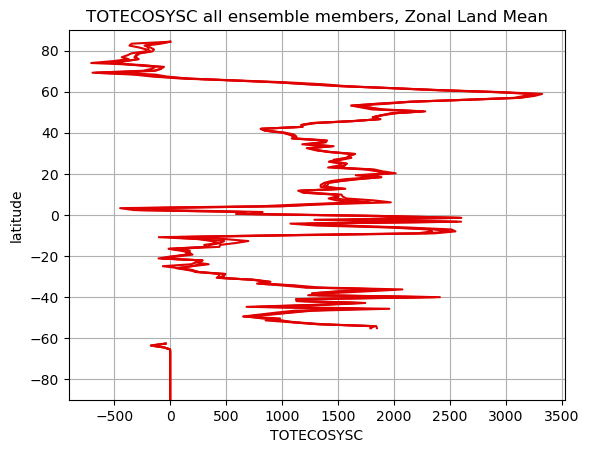

In [19]:
# all ensemble members for one experiment

var = 'TOTECOSYSC'


# the years specified here assume a historical run - needs to be modified for a future run
if c==0: #historical experiment
    endyear = 2015
    startyear = 1850
else: #future experiment
    endyear = 2100
    startyear = 2016

fig, axis = plt.subplots(1, 1) # initialize a figure

# loop over ensemble members
for ensm in range(ensnumlist[c]+1): # select an ensemble member
    
    casename = casenamelist[c] +str(ensm+1) #create a string of the casename

    ds = data_dict[casename] # retrieve the dataset from the dictionary of datasets

    zonal_ave=ds[var].groupby(ds['time.year']).mean(dim='time').mean(dim='lon')
    
    
    end_run = zonal_ave.sel(year=slice(endyear-20 ,endyear))
    beg_run = zonal_ave.sel(year=slice(startyear ,startyear+1))

    fg = (end_run.mean(dim='year') - beg_run.mean(dim='year')).plot(ax=axis,y='lat',color=colorlist[c]) 

axis.set_ylabel('')
plt.ylim([-90, 90])
axis.grid(True)
plt.title(var +' all ensemble members, Zonal Land Mean')
plt.ylabel('latitude')



In [21]:
c=0
ensm=0
casename = casenamelist[c] +str(ensm+1) #create a string of the casename
ds_r=data_dict[casename]


In [24]:
ds_r

<xarray.Dataset>
Dimensions:       (levgrnd: 25, levlak: 10, levdcmp: 25, lon: 288, lat: 192,
                   time: 1980, hist_interval: 2)
Coordinates:
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * lon           (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat           (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * time          (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: hist_interval
Data variables: (12/27)
    area          (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    landfrac      (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    landmask      (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    pftmask       (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    nbedrock      (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    ZSOI          (levgrnd, lat, lon) float32 dask.array<chunksize=(25, 192, 288), meta=np.ndarray>
    ...            ...
    GPP           (time, lat, lon) float32 dask.array<chunksize=(1980, 192, 288), meta=np.ndarray>
    NBP           (time, lat, lon) float32 dask.array<chunksize=(1980, 192, 288), meta=np.ndarray>
    TOTECOSYSC    (time, lat, lon) float32 dask.array<chunksize=(1980, 192, 288), meta=np.ndarray>
    TOTLITC       (time, lat, lon) float32 dask.array<chunksize=(1980, 192, 288), meta=np.ndarray>
    TOTSOMC       (time, lat, lon) float32 dask.array<chunksize=(1980, 192, 288), meta=np.ndarray>
    TOTVEGC       (time, lat, lon) float32 dask.array<chunksize=(1980, 192, 288), meta=np.ndarray>
Attributes: (12/100)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 06/21/24 01:31:30
    source:                                    Community Land Model CLM4.0
    hostname:                                  derecho
    ...                                        ...
    cft_irrigated_switchgrass:                 60
    cft_tropical_corn:                         61
    cft_irrigated_tropical_corn:               62
    cft_tropical_soybean:                      63
    cft_irrigated_tropical_soybean:            64
    time_period_freq:                          month_1